<a href="https://colab.research.google.com/github/elichen/nematode/blob/main/nematode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML, Image
from tqdm.notebook import tqdm
import random

In [37]:
grid_size = 40
num_pellets = 5
simulate_frames = 100

In [38]:
class WormEnvironment:
    def __init__(self, grid_size, num_pellets, controller):
        self.grid_size = grid_size
        self.num_pellets = num_pellets
        self.controller = controller
        self.reset_environment()

    def reset_environment(self):
        self.worm_position = (random.randint(0, self.grid_size-1), random.randint(0, self.grid_size-1))
        self.pellet_positions = [(random.randint(0, self.grid_size-1), random.randint(0, self.grid_size-1)) for _ in range(self.num_pellets)]
        self.score = 0

    def calculate_local_gradient(self, worm_position):
        """Calculate the chemical concentration gradient in the immediate vicinity of the worm."""
        x, y = worm_position
        # Initialize local gradient for all directions with zero
        local_gradient = {(0, -1): 0, (0, 1): 0, (-1, 0): 0, (1, 0): 0}

        # Consider only the immediate surroundings: up, down, left, and right
        for dx, dy in [(0, -1), (0, 1), (-1, 0), (1, 0)]:  # Directions: Up, Down, Left, Right
            adjacent_x, adjacent_y = x + dx, y + dy

            # Check bounds
            if 0 <= adjacent_x < self.grid_size and 0 <= adjacent_y < self.grid_size:
                gradient_value = 0
                for pellet in self.pellet_positions:
                    distance = np.sqrt((pellet[0] - adjacent_x) ** 2 + (pellet[1] - adjacent_y) ** 2)
                    gradient_value += max(0, 1 / (1 + distance))  # Simplified gradient calculation
                # Update gradient value for valid directions
                local_gradient[(dx, dy)] = gradient_value

        return local_gradient

    def update(self):
        """Update the environment state based on the worm's decision to move based on local gradients."""
        local_gradient = self.calculate_local_gradient(self.worm_position)
        move_direction = self.controller.decide_move(local_gradient)
        new_position = (min(max(self.worm_position[0] + move_direction[0], 0), self.grid_size-1),
                        min(max(self.worm_position[1] + move_direction[1], 0), self.grid_size-1))
        self.worm_position = new_position
        if self.worm_position in self.pellet_positions:
            self.pellet_positions.remove(self.worm_position)
            self.score += 1
        return self.worm_position, self.pellet_positions, self.score

    def draw(self):
        grid = np.zeros((self.grid_size, self.grid_size))
        grid[self.worm_position] = -1  # Worm's position
        for pellet in self.pellet_positions:
            grid[pellet] = 1  # Pellet's position
        return grid

In [39]:
class HeuristicController:
    def decide_move(self, local_gradient):
        # Find the direction with the highest gradient value
        max_gradient = -float('inf')
        move_direction = (0, 0)
        for direction, gradient_value in local_gradient.items():
            if gradient_value > max_gradient:
                max_gradient = gradient_value
                move_direction = direction

        return move_direction

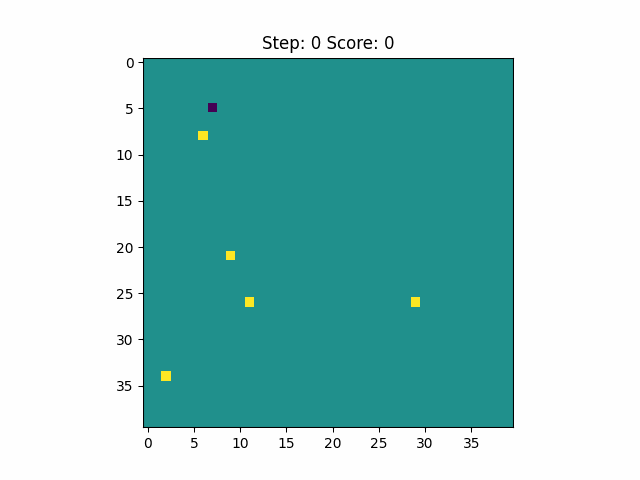

In [40]:
fig, ax = plt.subplots()
environment = WormEnvironment(grid_size, num_pellets, HeuristicController())

def animate(i):
    ax.clear()
    position, pellets, score = environment.update()
    grid = environment.draw()
    ax.imshow(grid, cmap='viridis')
    ax.set_title(f'Step: {i} Score: {score}')
    return ax

ani = animation.FuncAnimation(fig, animate, frames=simulate_frames, interval=100, blit=False, repeat=False)

ani.save('HeuristicController.gif', writer='pillow', fps=10)
plt.close(fig)
Image(filename='HeuristicController.gif')

In [41]:
inputs = []
outputs = []

environment = WormEnvironment(grid_size, num_pellets, HeuristicController())
for _ in range(100000):
    # Reset the environment to a random state for each instance
    environment.reset_environment()

    # Calculate the local gradient around the worm
    local_gradient = environment.calculate_local_gradient(environment.worm_position)

    # Create input feature vector from the local gradients
    input_features = [local_gradient.get((0, -1), 0),  # Gradient Up
                      local_gradient.get((0, 1), 0),   # Gradient Down
                      local_gradient.get((-1, 0), 0),  # Gradient Left
                      local_gradient.get((1, 0), 0)]   # Gradient Right
    inputs.append(input_features)

    # Use HeuristicController to determine the optimal move direction
    heuristic_move = environment.controller.decide_move(local_gradient)
    output_label = [(0, -1) == heuristic_move,  # Up
                    (0, 1) == heuristic_move,   # Down
                    (-1, 0) == heuristic_move,  # Left
                    (1, 0) == heuristic_move]   # Right
    outputs.append(output_label)

In [42]:
class NeuralController(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralController, self).__init__()
        # Define the architecture of the neural network
        self.network = nn.Sequential(
            nn.Linear(input_size, 128),  # Input layer to hidden layer
            nn.ReLU(),  # Activation function
            nn.Linear(128, output_size),  # Hidden layer to output layer
        )

    def forward(self, x):
        return self.network(x)

    def decide_move(self, local_gradient):
        gradient_values = [local_gradient.get(direction, 0) for direction in [(0, -1), (0, 1), (-1, 0), (1, 0)]]
        # Convert local gradient to a tensor
        gradient_tensor = torch.FloatTensor([gradient_values]).to(next(self.parameters()).device)

        # Predict the move direction using the neural network
        with torch.no_grad():
            prediction = self.forward(gradient_tensor)

        probabilities = F.softmax(prediction, dim=1)
        move_index = torch.multinomial(probabilities, 1).item()
        direction_mapping = {0: (0, -1),  # Up
                             1: (0, 1),   # Down
                             2: (-1, 0),  # Left
                             3: (1, 0)}   # Right
        move_direction = direction_mapping[move_index]

        return move_direction

In [43]:
inputs_tensor = torch.tensor(inputs, dtype=torch.float)
outputs_tensor = torch.tensor(outputs, dtype=torch.long)
_, labels_indices = torch.max(outputs_tensor, 1)
dataset = TensorDataset(inputs_tensor, labels_indices)  # Use class indices for labels
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)  # Shuffling is not necessary for validation

In [44]:
supervised_model = NeuralController(input_size=4, output_size=4)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(supervised_model.parameters(), lr=3e-3)
num_epochs = 10

for epoch in range(num_epochs):
    supervised_model.train()  # Set the model to training mode
    total_train_loss = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = supervised_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    # Validation phase
    supervised_model.eval()  # Set the model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():  # No need to track gradients for validation
        for inputs, labels in val_loader:
            outputs = supervised_model(inputs)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

Epoch 1/10, Training Loss: 0.9213, Validation Loss: 0.6547
Epoch 2/10, Training Loss: 0.5287, Validation Loss: 0.4129
Epoch 3/10, Training Loss: 0.3641, Validation Loss: 0.3188
Epoch 4/10, Training Loss: 0.2846, Validation Loss: 0.2496
Epoch 5/10, Training Loss: 0.2403, Validation Loss: 0.2239
Epoch 6/10, Training Loss: 0.2123, Validation Loss: 0.1908
Epoch 7/10, Training Loss: 0.1948, Validation Loss: 0.1835
Epoch 8/10, Training Loss: 0.1810, Validation Loss: 0.1648
Epoch 9/10, Training Loss: 0.1728, Validation Loss: 0.1537
Epoch 10/10, Training Loss: 0.1624, Validation Loss: 0.1601


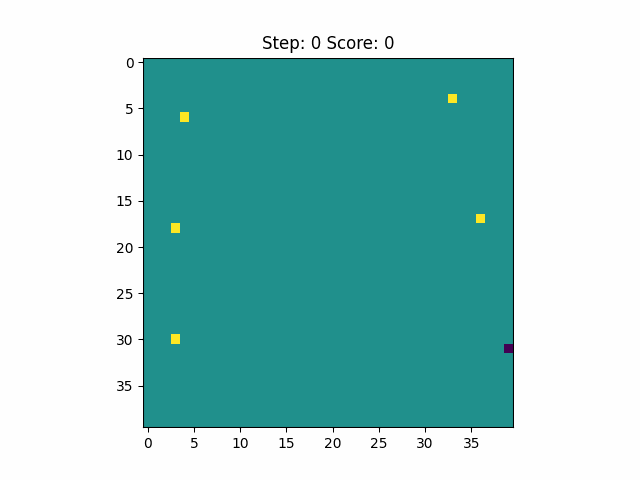

In [45]:
fig, ax = plt.subplots()
supervised_model.eval()
environment = WormEnvironment(grid_size, num_pellets, supervised_model)

def animate(i):
    ax.clear()
    position, pellets, score = environment.update()
    grid = environment.draw()
    ax.imshow(grid, cmap='viridis')
    ax.set_title(f'Step: {i} Score: {score}')
    return ax

ani = animation.FuncAnimation(fig, animate, frames=simulate_frames, interval=100, blit=False, repeat=False)

ani.save('supervised_model.gif', writer='pillow', fps=10)
plt.close(fig)
Image(filename='supervised_model.gif')

In [76]:
self_learned_controller = NeuralController(4,4)
environment = WormEnvironment(grid_size=10, num_pellets=5, controller=self_learned_controller)

# Training setup
optimizer = optim.Adam(self_learned_controller.parameters(), lr=0.003)
epochs = 10  # Number of episodes

for epoch in range(epochs):
    total_loss = 0
    num_iterations = 1000  # Number of iterations per epoch

    for _ in range(num_iterations):
      environment.reset_environment()
      gradient = environment.calculate_local_gradient(environment.worm_position)
      input_features = [gradient.get((0, -1), 0),  # Gradient Up
                        gradient.get((0, 1), 0),   # Gradient Down
                        gradient.get((-1, 0), 0),  # Gradient Left
                        gradient.get((1, 0), 0)]   # Gradient Right
      input_tensor = torch.tensor(input_features, dtype=torch.float)
      logits = self_learned_controller(input_tensor.unsqueeze(0))  # Add batch dimension
      best_action = torch.argmax(torch.tensor(input_features)).item()
      loss = F.cross_entropy(logits, torch.tensor([best_action]))  # Cross-Entropy Loss
      optimizer.zero_grad()  # Clear existing gradients
      loss.backward()  # Compute gradients of loss w.r.t. model parameters
      optimizer.step()  # Adjust model parameters
      total_loss += loss.item()  # Accumulate the loss

    average_loss = total_loss / num_iterations  # Calculate average loss for the epoch
    print(f"Epoch {epoch+1}, Average Loss: {average_loss}")

Epoch 1, Average Loss: 0.8432824659846956
Epoch 2, Average Loss: 0.5225067496823794
Epoch 3, Average Loss: 0.3805083582144334
Epoch 4, Average Loss: 0.3809106204436252
Epoch 5, Average Loss: 0.3361822031619408
Epoch 6, Average Loss: 0.3093605760405657
Epoch 7, Average Loss: 0.32782100702199013
Epoch 8, Average Loss: 0.24297944381291084
Epoch 9, Average Loss: 0.2832553163128444
Epoch 10, Average Loss: 0.2723565851253197


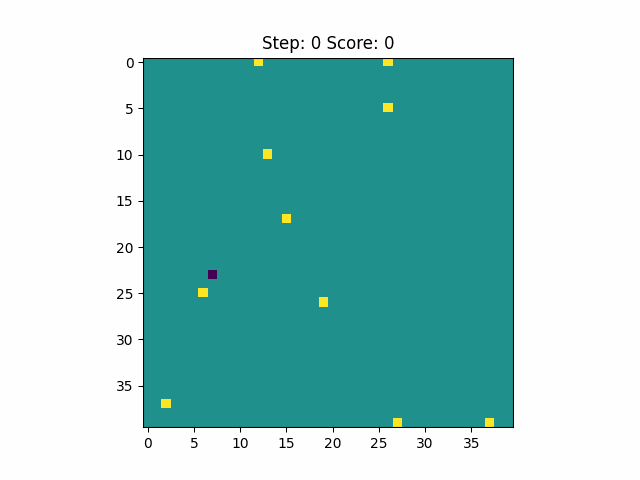

In [78]:
fig, ax = plt.subplots()
self_learned_controller.eval()
environment = WormEnvironment(grid_size, 10, self_learned_controller)

def animate(i):
    ax.clear()
    position, pellets, score = environment.update()
    grid = environment.draw()
    ax.imshow(grid, cmap='viridis')
    ax.set_title(f'Step: {i} Score: {score}')
    return ax

ani = animation.FuncAnimation(fig, animate, frames=simulate_frames, interval=100, blit=False, repeat=False)

ani.save('self_learned_controller.gif', writer='pillow', fps=10)
plt.close(fig)
Image(filename='self_learned_controller.gif')